# Accessing and analysing web resources with pygplates

### Overview

This notebook goes through the steps of
- accessing geoscientific data directly from web servers and loading into python
- converting these data into a GPlates-compatible version
- carrying out spatial analysis that compares fossil occurences to the locations of interpreted paleoshorelines through geological time


### Part 1

The first part of this exercise goes through the actions of getting data sets directly from web services, and loading them into your python workspace. 

Let's start by doing something that has nothing to do with GPlates whatsoever. We use a python module called 'requests' to make a request to a web service run by the USGS, and load the data into a pandas dataframe (the function 'StringIO' is also used to help pandas recognise the data stream that comes back from the USGS web service as something resembling a csv file).

Note that when you run the next cell, you will have to wait for a while as the data is downloaded.

To quickly see what is in returned data, we can print the resulting text, which reveals a stream of data in csv format.


In [13]:
import requests
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# make the web request. The result will be in the object 'r'
r = requests.get('http://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&endtime=2017-01-01T00:00:00.000Z&minsig=500&starttime=2016-01-01T00:00:00.000Z')

print r.text


time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
2016-12-29T22:30:19.300Z,-9.0279,118.6639,79,6.3,mww,,26,3.553,1.42,us,us10007nl0,2017-02-10T04:52:26.603Z,"29km S of Tolotangga, Indonesia",earthquake,6.2,1.8,,,reviewed,us,us
2016-12-28T12:38:49.650Z,36.8604,140.4421,7,5.9,mww,,33,1.044,0.91,us,us10007naf,2017-02-16T09:09:22.687Z,"13km NE of Daigo, Japan",earthquake,4.6,1.7,,,reviewed,us,us
2016-12-28T09:13:47.243Z,38.3777,-118.8957,8.8,5.5,ml,33,48.58,0.129,0.2187,nn,nn00570744,2017-02-27T19:41:54.800Z,"28km SW of Hawthorne, Nevada",earthquake,,2,0.26,18,reviewed,nn,nn
2016-12-28T08:22:12.208Z,38.3904,-118.8972,12.2,5.6,ml,43,42.44,0.123,0.1913,nn,nn00570710,2017-02-18T12:46:58.539Z,"26km SW of Hawthorne, Nevada",earthquake,,1.2,0.32,18,reviewed,nn,nn
2016-12-28T08:18:00.613Z,38.3755,-118.8989,11.3,5.6,ml,37,35.89,0.133,0.1599,nn,nn00570709,2017-03-08T19:14:51.635Z,"28km WSW 

The returned information will be more useful if we store it in a structured dataframe with column names:

In [14]:
# read the returned data into a pandas dataframe
df = pd.read_csv(StringIO(r.text))

print df

                         time   latitude   longitude    depth   mag magType  \
0    2016-12-29T22:30:19.300Z  -9.027900  118.663900   79.000  6.30     mww   
1    2016-12-28T12:38:49.650Z  36.860400  140.442100    7.000  5.90     mww   
2    2016-12-28T09:13:47.243Z  38.377700 -118.895700    8.800  5.50      ml   
3    2016-12-28T08:22:12.208Z  38.390400 -118.897200   12.200  5.60      ml   
4    2016-12-28T08:18:00.613Z  38.375500 -118.898900   11.300  5.60      ml   
5    2016-12-27T23:20:56.110Z  45.719500   26.522900   97.000  5.60     mww   
6    2016-12-25T14:22:27.020Z -43.406300  -73.943800   38.000  7.60     mww   
7    2016-12-24T03:58:54.680Z  -5.146000  153.516600   30.000  5.80     mww   
8    2016-12-24T01:32:16.040Z  -5.245300  153.575400   35.000  6.00     mww   
9    2016-12-21T16:43:56.770Z  21.513800  145.408100    8.000  5.90     mww   
10   2016-12-21T00:17:14.990Z  -7.508200  127.920600  152.000  6.70     mww   
11   2016-12-20T12:33:14.240Z -10.178500  160.914900

Plotting the data shows us a bit more about what we have downloaded

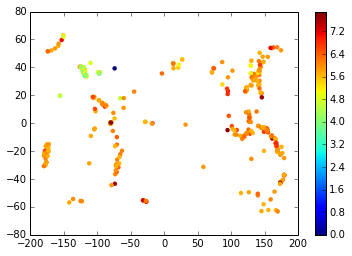

In [15]:
plt.scatter(df.longitude,df.latitude,c=df.mag,edgecolor='')
plt.colorbar()
plt.show()


### Questions:

- What exactly did we request, and what are we plotting?
- How can we vary the request to get a different subset of the data within the catalogue we are accessing
- Can you write a loop that creates a time-series of images with data for different time periods?


### Fossils

Go to this site:

https://paleobiodb.org/navigator/

As well as playing around with the interface, you should be able to find a way to access the data via http requests just like the one above. In fact, you can use the pbdb navigator to select which type of subset of the database (fossil type, geological period) you want to download. The navigator will provide you with a url that describes the request including the selection criteria you set.

Try to load a subset of the fossil data into a pandas dataframe, following a similar recipe to that described above

Note, there is at least one non-obvious trick here, which is that you need to specify the output format that you want the data to be sent to you in. You'll need to set this in the http request string.  
[HINT: the default is 'json', buit you don't want that.]

Download some data and figure out which columns contain what information.  
[you can see the column names for any dataframe by running 'df.columns']


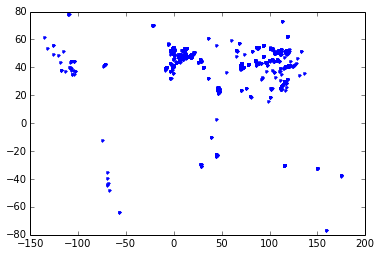

In [16]:
# SOLUTION
r = requests.get('https://paleobiodb.org/data1.1/occs/list.csv?limit=all&interval_id=15&base_id=18891&show=coords,attr,loc,prot,time,strat,stratext,lith,lithext,geo,rem,ent,entname,crmod&showsource')

#print r.text

df = pd.read_csv(StringIO(r.text),skiprows=15)

plt.plot(df.lng,df.lat,'.')


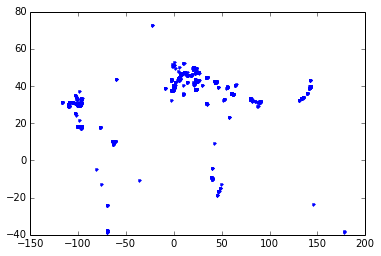

In [17]:
r = requests.get('https://paleobiodb.org/data1.1/occs/list.csv?limit=all&interval_id=40&base_id=4524&show=coords,attr,loc,prot,time,strat,stratext,lith,lithext,geo,rem,ent,entname,crmod&showsource')

df = pd.read_csv(StringIO(r.text),skiprows=15)

plt.plot(df.lng,df.lat,'.')


#### Creating a GPlates Feature Collection

To do something with these fossil data - either with GPlates or pygplates - we first need to convert the data into a 'feature collection'. The following example shows how to take the coordinates from each fossil occurence in the dataframe and make a GPlates 'Point feature'. We append each feature to a big list of features, then save this to a 'Feature Collection' that GPlates can read.

In [18]:
import pygplates

fossil_point_features = []
for index,row in df.iterrows():
    point = pygplates.PointOnSphere(float(row.lat),float(row.lng))
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    fossil_point_features.append(point_feature)
    
# Having created a list of features, we need to tell pygplates that this is a coherent 'Feature Collection'
# Then, we can save it to a file
# [note that the file format is controlled by the file extension we enter - can be *.gpml, *.gmt or *.shp]
output_feature_collection = pygplates.FeatureCollection(fossil_point_features)
output_feature_collection.write('my_fossils.gpml')


Load this feature collection into GPlates and look at it.

Questions:
- what information is missing from this feature collection that would be useful to assign to it?
- how can we assign that information (either in GPlates or within the python notebook)?  

HINTS: 
- one of the tutorials should help on this point
- the set_shapefile_attribute('')


### Part 2: Fossils and depositional environments

The rest of this notebook begins to consider the question 'what do fossils tell us about paleoenvironments?'

First, look at what types of attributes we have for each fossil, by listing the columns


In [19]:
df.columns

Index([u'occurrence_no', u'record_type', u'reid_no', u'superceded',
       u'collection_no', u'taxon_name', u'taxon_rank', u'taxon_no',
       u'matched_name', u'matched_rank', u'matched_no', u'early_interval',
       u'late_interval', u'early_age', u'late_age', u'reference_no', u'lng',
       u'lat', u'cc', u'state', u'county', u'geogscale', u'protected',
       u'early_age.1', u'late_age.1', u'cx_int_no', u'early_int_no',
       u'late_int_no', u'formation', u'stratgroup', u'member', u'stratscale',
       u'zone', u'localsection', u'localbed', u'localorder',
       u'regionalsection', u'regionalbed', u'regionalorder', u'stratcomments',
       u'lithdescript', u'lithology1', u'lithadj1', u'lithification1',
       u'minor_lithology1', u'fossilsfrom1', u'lithology2', u'lithadj2',
       u'lithification2', u'minor_lithology2', u'fossilsfrom2', u'environment',
       u'tectonic_setting', u'geology_comments', u'collection_aka',
       u'authorizer_no', u'enterer_no', u'modifier_no', u'auth

We are going to focus on the column called 'environment', which contains information about the sedimentary depositional environment of the rock that hosts the fossil (at least according to the interpretation of the geologist who found the fossil). Let's look at the values in that column (only the first part of the full dataframe is listed)

In [20]:
df.environment

0                           NaN
1                 marine indet.
2                           NaN
3                           NaN
4                           NaN
5                           NaN
6                           NaN
7                           NaN
8                 marine indet.
9                 marine indet.
10                marine indet.
11                marine indet.
12                marine indet.
13                marine indet.
14                marine indet.
15                marine indet.
16                marine indet.
17                marine indet.
18                marine indet.
19      shallow subtidal indet.
20      shallow subtidal indet.
21      shallow subtidal indet.
22      shallow subtidal indet.
23      shallow subtidal indet.
24      shallow subtidal indet.
25      shallow subtidal indet.
26      shallow subtidal indet.
27      shallow subtidal indet.
28      shallow subtidal indet.
29      shallow subtidal indet.
                 ...           
3001    

A useful method that can be applied to pandas dataframes is 'unique' - this lists all the different unique types of enivironment that are found in the 'environment' column. 

In [21]:
print df.environment.unique()


[nan 'marine indet.' 'shallow subtidal indet.' 'reef, buildup or bioherm'
 'deep subtidal shelf' 'open shallow subtidal'
 'lagoonal/restricted shallow subtidal' 'marginal marine indet.'
 'shoreface' 'deltaic indet.' 'offshore' 'deep subtidal ramp'
 'perireef or subreef' 'coastal indet.' 'basinal (siliciclastic)'
 'platform/shelf-margin reef' 'submarine fan' 'deep subtidal indet.'
 'carbonate indet.' 'offshore indet.' 'offshore ramp' 'slope/ramp reef']


when we load data into a pandas dataframe object, we have access to a wide variety of methods that can operate on the data. For example, suppose we want to find all the rows in the dataframe where the 'environment' field contains the string 'marine' somewhere within the environment description: 

In [22]:
df.environment.str.contains('marine')

0         NaN
1        True
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
3001    False
3002    False
3003     True
3004     True
3005    False
3006    False
3007    False
3008    False
3009    False
3010    False
3011    False
3012    False
3013    False
3014    False
3015    False
3016    False
3017    False
3018    False
3019    False
3020    False
3021    False
3022    False
3023    False
3024    False
3025    False
3026    False
3027    False
3028    False
3029    False
3030    False
Name: environment, dtype: object

In the above, we get back a list of boolean results that are True where the environment string contains marine, False where it does not (And NaN, Not-a-Number, where the original field was also NaN)

We can use this result as an index to create a new, smaller dataframe that only contains the rows where the criteria we set are satisfied. Once we've made the subset dataframe, we can print the unique values in the environment column just for that dataframe, to check that our selection has worked. 

In [23]:
subset = df.where(df.environment.str.contains('marine'))

print subset.environment.unique()

[nan 'marine indet.' 'marginal marine indet.' 'submarine fan']


To see the spatial distribution of the data we have selected, we can plot a quick map 

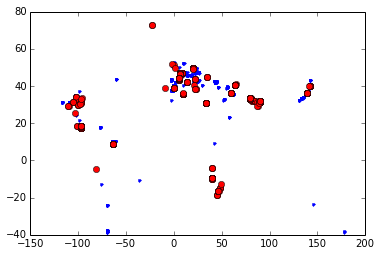

In [24]:
plt.plot(df.lng,df.lat,'b.')
plt.plot(subset.lng,subset.lat,'ro')
plt.show()


#### Questions

- what happens when you try a different search string? For example 'reef', or 'offshore'?
- how will you precisely formulate a test of consistency between paleoshorelines and the fossil points?
